In [ ]:
import torch

seq_lens_kv = torch.ones(64) * 1000
mask = torch.full((4, 4), 0)
mask_cond = torch.arange(mask.size(-1))
mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 1)
mask

tensor([[1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 1]])

In [17]:
mask.cumsum(-1)

tensor([[1, 2, 2, 2],
        [1, 2, 2, 2],
        [1, 2, 3, 3],
        [1, 2, 3, 4]])

In [8]:
mask.cumsum(-1)

tensor([[1, 1, 1, 1],
        [1, 2, 2, 2],
        [1, 2, 3, 3],
        [1, 2, 3, 4]])

In [5]:
mask.shape

torch.Size([4, 104])

In [1]:
import numpy as np

def idct_64_matrix():
    N = 8
    M = np.zeros((N*N, N*N))
    for i in range(N):
        for j in range(N):
            k = i * N + j
            for u in range(N):
                alpha_u = np.sqrt(1/N) if u == 0 else np.sqrt(2/N)
                cos_i_u = np.cos((2*i + 1) * u * np.pi / 16)
                for v in range(N):
                    l = u * N + v
                    alpha_v = np.sqrt(1/N) if v == 0 else np.sqrt(2/N)
                    cos_j_v = np.cos((2*j + 1) * v * np.pi / 16)
                    M[k, l] = (alpha_u * alpha_v * cos_i_u * cos_j_v)**2
    return M

In [6]:
M = idct_64_matrix()
x = np.array(stds)
z = M @ x
x = range(64)
z

array([4.15385873, 4.33216572, 4.16165847, 4.22059829, 4.22059829,
       4.16165847, 4.33216572, 4.15385873, 4.31840106, 4.00766069,
       3.94779032, 3.99742599, 3.99742599, 3.94779032, 4.00766069,
       4.31840106, 4.23189914, 4.00582138, 3.90938027, 3.95458783,
       3.95458783, 3.90938027, 4.00582138, 4.23189914, 4.24133982,
       3.9895529 , 3.93569704, 3.96673913, 3.96673913, 3.93569704,
       3.9895529 , 4.24133982, 4.24133982, 3.9895529 , 3.93569704,
       3.96673913, 3.96673913, 3.93569704, 3.9895529 , 4.24133982,
       4.23189914, 4.00582138, 3.90938027, 3.95458783, 3.95458783,
       3.90938027, 4.00582138, 4.23189914, 4.31840106, 4.00766069,
       3.94779032, 3.99742599, 3.99742599, 3.94779032, 4.00766069,
       4.31840106, 4.15385873, 4.33216572, 4.16165847, 4.22059829,
       4.22059829, 4.16165847, 4.33216572, 4.15385873])

In [ ]:
import numpy as np
# 假设你已经有 A (64x64) 和 目标向量 t (64,)
# 下面演示如何计算距离

A = idct_64_matrix()

# 1. SVD 得到零空间基 M
U, s, Vt = np.linalg.svd(A)      # A = U @ diag(s) @ Vt
rank = np.sum(s > 1e-10)        # or 使用已知的 16
M = Vt.T[:, int(rank):]         # M 的列为 nullspace basis

# 2. 构造 B
ones = np.ones((64,1))
B = np.concatenate([ones, M], axis=1)   # 64 x (1 + null_dim)

# 3. 最小二乘求解 p
p, *_ = np.linalg.lstsq(B, t, rcond=None)  # p 长度 = 1 + null_dim

# 4. 残差与距离
residual = t - B.dot(p)
distance = np.linalg.norm(residual)   # 这是 dist(t, S)

print("distance to S:", distance)
# 如果你也想要投影向量（S 中的最近点）：
t_proj = B.dot(p)

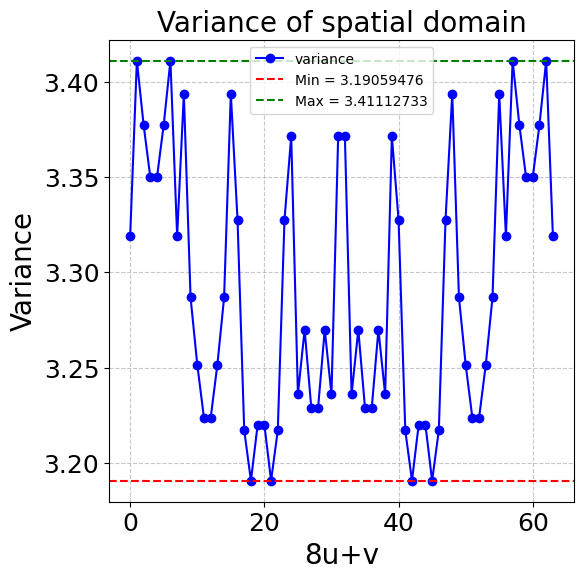

In [34]:

import matplotlib.pyplot as plt

# Example data points
x = range(64)
y = [3.31907817, 3.41112733, 3.3775552 , 3.34999595, 3.34999595,
       3.3775552 , 3.41112733, 3.31907817, 3.39373921, 3.28684876,
       3.25159648, 3.22361342, 3.22361342, 3.25159648, 3.28684876,
       3.39373921, 3.32768714, 3.21700527, 3.19059476, 3.22001794,
       3.22001794, 3.19059476, 3.21700527, 3.32768714, 3.37151381,
       3.23593354, 3.26992767, 3.22867374, 3.22867374, 3.26992767,
       3.23593354, 3.37151381, 3.37151381, 3.23593354, 3.26992767,
       3.22867374, 3.22867374, 3.26992767, 3.23593354, 3.37151381,
       3.32768714, 3.21700527, 3.19059476, 3.22001794, 3.22001794,
       3.19059476, 3.21700527, 3.32768714, 3.39373921, 3.28684876,
       3.25159648, 3.22361342, 3.22361342, 3.25159648, 3.28684876,
       3.39373921, 3.31907817, 3.41112733, 3.3775552 , 3.34999595,
       3.34999595, 3.3775552 , 3.41112733, 3.31907817]

y_min = min(y)
y_max = max(y)

plt.figure(figsize=(6, 6))
plt.plot(x, y, marker="o", color="blue", label="variance")
plt.axhline(y=y_min, color="red", linestyle="--", label=f"Min = {y_min}")
plt.axhline(y=y_max, color="green", linestyle="--", label=f"Max = {y_max}")
plt.title(f"Variance of spatial domain", fontsize=20)
plt.xlabel("8u+v", fontsize=20)
plt.ylabel("Variance", fontsize=20)
plt.tick_params(axis='x', labelsize=18)  # 横轴字号
plt.tick_params(axis='y', labelsize=18)  # 纵轴字号
# plt.ylim(0, 6)  # Set y-axis range
# plt.xlim(-100, 100)  # Set y-axis range
plt.savefig("var.png", dpi=300, bbox_inches="tight")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

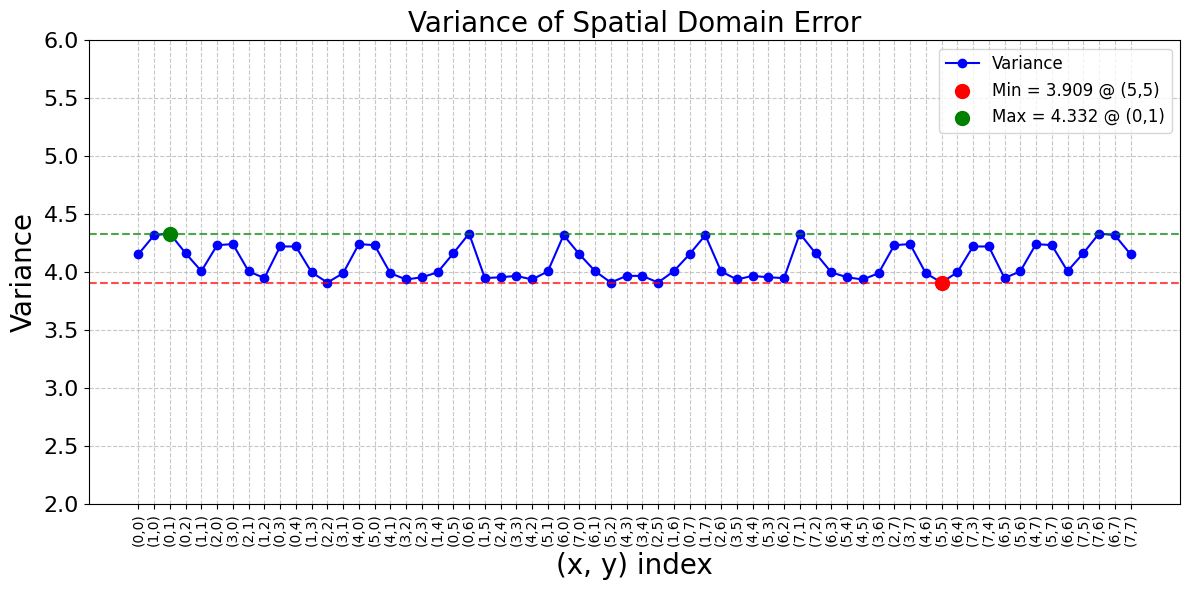

In [10]:
import matplotlib.pyplot as plt

def zigzag_indices(n=8):
    indices = []
    for s in range(2*n-1):
        if s % 2 == 0:
            # 偶数：从下往上
            for i in range(s+1):
                j = s - i
                if i < n and j < n:
                    indices.append((i, j))
        else:
            # 奇数：从上往下
            for i in range(s+1):
                j = s - i
                if j < n and i < n:
                    indices.append((j, i))
    return indices

zigzag = zigzag_indices(8)

# 模拟一些误差方差数据
values = z

# 按 zigzag 顺序重新排列
zigzag_values = [values[u*8 + v] for (u, v) in zigzag]

y = zigzag_values

# 生成 (u,v) 坐标标签
label = [f"({u},{v})" for u in range(8) for v in range(8)]
labels = [f"({u},{v})" for (u, v) in zigzag]
x = range(64)

y_min = min(y)
y_max = max(y)
x_min = x[y.index(y_min)]
x_max = x[y.index(y_max)]

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker="o", color="blue", label="Variance")

# 高亮最大/最小值
plt.scatter(x_min, y_min, color="red", s=100, zorder=5, label=f"Min = {y_min:.3f} @ {labels[x_min]}")
plt.scatter(x_max, y_max, color="green", s=100, zorder=5, label=f"Max = {y_max:.3f} @ {labels[x_max]}")

# 水平线
plt.axhline(y=y_min, color="red", linestyle="--", alpha=0.7)
plt.axhline(y=y_max, color="green", linestyle="--", alpha=0.7)

plt.title("Variance of Spatial Domain Error", fontsize=20)
plt.xlabel("(x, y) index", fontsize=20)
plt.ylabel("Variance", fontsize=20)

# 设置x轴刻度为 (u,v)
plt.xticks(ticks=x, labels=labels, rotation=90, fontsize=10)
plt.tick_params(axis='y', labelsize=16)

plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.ylim(2, 6)
plt.savefig("var_uv.png", dpi=300, bbox_inches="tight")
plt.show()

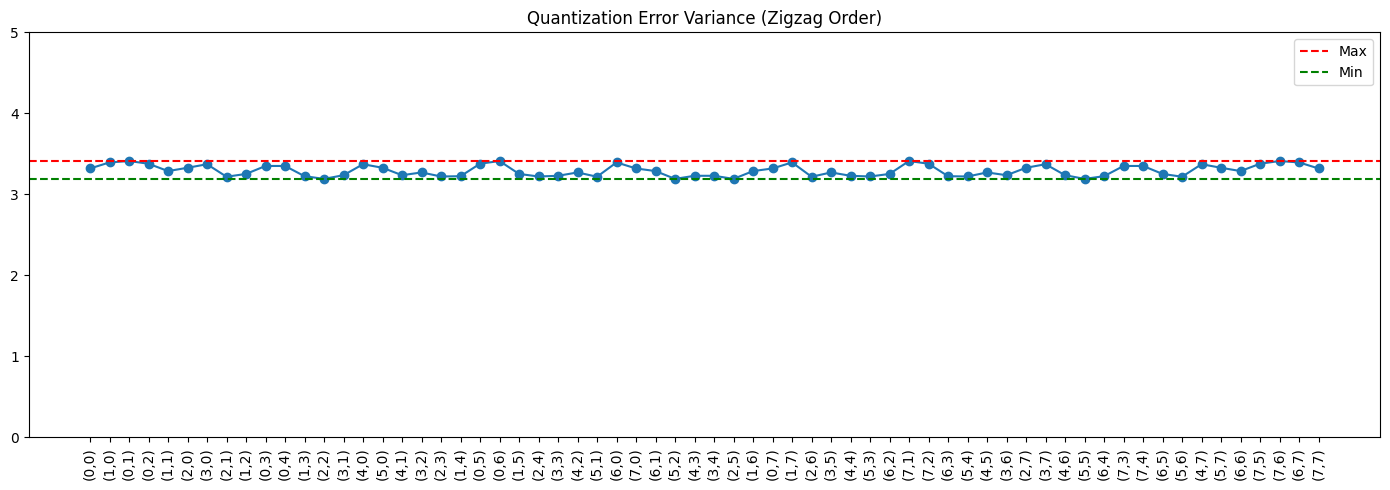

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 构建 8x8 zigzag 扫描顺序
def zigzag_indices(n=8):
    indices = []
    for s in range(2*n-1):
        if s % 2 == 0:
            # 偶数：从下往上
            for i in range(s+1):
                j = s - i
                if i < n and j < n:
                    indices.append((i, j))
        else:
            # 奇数：从上往下
            for i in range(s+1):
                j = s - i
                if j < n and i < n:
                    indices.append((j, i))
    return indices

zigzag = zigzag_indices(8)

# 模拟一些误差方差数据
values = [3.31907817, 3.41112733, 3.3775552 , 3.34999595, 3.34999595,
       3.3775552 , 3.41112733, 3.31907817, 3.39373921, 3.28684876,
       3.25159648, 3.22361342, 3.22361342, 3.25159648, 3.28684876,
       3.39373921, 3.32768714, 3.21700527, 3.19059476, 3.22001794,
       3.22001794, 3.19059476, 3.21700527, 3.32768714, 3.37151381,
       3.23593354, 3.26992767, 3.22867374, 3.22867374, 3.26992767,
       3.23593354, 3.37151381, 3.37151381, 3.23593354, 3.26992767,
       3.22867374, 3.22867374, 3.26992767, 3.23593354, 3.37151381,
       3.32768714, 3.21700527, 3.19059476, 3.22001794, 3.22001794,
       3.19059476, 3.21700527, 3.32768714, 3.39373921, 3.28684876,
       3.25159648, 3.22361342, 3.22361342, 3.25159648, 3.28684876,
       3.39373921, 3.31907817, 3.41112733, 3.3775552 , 3.34999595,
       3.34999595, 3.3775552 , 3.41112733, 3.31907817]

# 按 zigzag 顺序重新排列
zigzag_values = [values[u*8 + v] for (u, v) in zigzag]

# 生成标签
labels = [f"({u},{v})" for (u, v) in zigzag]

# 绘图
plt.figure(figsize=(14, 5))
plt.plot(range(64), zigzag_values, marker="o", linestyle="-")
plt.xticks(range(64), labels, rotation=90)
plt.ylim(0, 5)

# 在最大值和最小值画横线
plt.axhline(y=max(zigzag_values), color="r", linestyle="--", label="Max")
plt.axhline(y=min(zigzag_values), color="g", linestyle="--", label="Min")
plt.legend()
plt.title("Quantization Error Variance (Zigzag Order)")
plt.tight_layout()
plt.show()

In [4]:
A = M[:,1:]
A[:4,:4]
A.shape

(64, 63)

Matplotlib is building the font cache; this may take a moment.


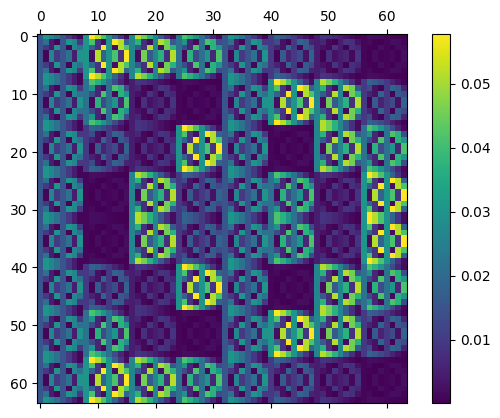

In [6]:
import matplotlib.pyplot as plt
figure = plt.figure()
axes = figure.add_subplot(111)

# using the matshow() function 
caxes = axes.matshow(M, interpolation ='nearest')
figure.colorbar(caxes)

In [34]:
A

array([[3.00606177e-02, 2.66735435e-02, 2.16044286e-02, ...,
        7.34225402e-04, 3.48362012e-04, 9.05363370e-05],
       [2.16044286e-02, 4.57645654e-03, 1.18938230e-03, ...,
        2.28822827e-03, 2.03040260e-03, 7.34225402e-04],
       [9.64557137e-03, 4.57645654e-03, 3.00606177e-02, ...,
        9.05363370e-05, 2.03040260e-03, 1.64453921e-03],
       ...,
       [9.64557137e-03, 4.57645654e-03, 3.00606177e-02, ...,
        9.05363370e-05, 2.03040260e-03, 1.64453921e-03],
       [2.16044286e-02, 4.57645654e-03, 1.18938230e-03, ...,
        2.28822827e-03, 2.03040260e-03, 7.34225402e-04],
       [3.00606177e-02, 2.66735435e-02, 2.16044286e-02, ...,
        7.34225402e-04, 3.48362012e-04, 9.05363370e-05]])

In [ ]:
import numpy as np

# 构造 b 为全 1 向量 (64,)
b = np.ones(64)

# 最小二乘解
x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

print("解向量 x 的形状:", x.shape)
print("解向量 x =", x)

# 验证 Ax 是否接近 b
print("Ax ≈", M @ x)
print("残差 ||Ax - b||^2 =", np.sum((M @ x - b) ** 2))

解向量 x 的形状: (64,)
解向量 x = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Ax ≈ [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/2439611760.py:13: RuntimeWarning: divide by zero encountered in matmul
  print("Ax ≈", M @ x)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/2439611760.py:13: RuntimeWarning: overflow encountered in matmul
  print("Ax ≈", M @ x)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/2439611760.py:13: RuntimeWarning: invalid value encountered in matmul
  print("Ax ≈", M @ x)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 63)

In [8]:
S

array([1.00000000e+00, 3.53553391e-01, 3.53553391e-01, 3.53553391e-01,
       3.53553391e-01, 3.53553391e-01, 3.53553391e-01, 1.25000000e-01,
       1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01,
       1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01,
       3.56127538e-16, 3.22762607e-16, 2.27329071e-16, 2.11001074e-16,
       1.79701547e-16, 1.73702926e-16, 1.69724686e-16, 1.04739796e-16,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
       9.91363733e-17, 9.91363733e-17, 9.91363733e-17, 9.91363733e-17,
      

In [7]:
U, S, Vt = np.linalg.svd(M)
tol = 1e-10
null_mask = (S <= tol)
null_space = Vt[null_mask].T if np.any(null_mask) else np.zeros((M.shape[1], 0))

In [83]:
import numpy as np
from scipy.linalg import null_space


# 求零空间
ns = null_space(A)

print("零空间基向量:\n", ns)

# 取一个非平凡解（任意一个零空间向量）
if ns.size > 0:
    x_nontrivial = ns[:, 0]  # 取第一列
    print("一个非平凡解 x =", x_nontrivial)
else:
    print("只有平凡解 x=0")

零空间基向量:
 [[ 0.03810383 -0.0367014   0.09683015 ...  0.52335692  0.
  -0.75659918]
 [-0.10521501 -0.09185384 -0.25181708 ... -0.14151019 -0.06689349
  -0.07283661]
 [ 0.0294893  -0.08007453  0.07631684 ...  0.2363203  -0.02384244
   0.15009158]
 ...
 [-0.02988367 -0.00181466  0.05396574 ...  0.01653257 -0.14337529
  -0.03273136]
 [-0.1172428  -0.01606373 -0.14723509 ... -0.17646225  0.01898731
  -0.13447228]
 [ 0.00327675 -0.02361118  0.10795808 ...  0.05617764  0.05264093
   0.04730083]]
一个非平凡解 x = [ 0.03810383 -0.10521501  0.0294893   0.29931341 -0.00303882 -0.04687658
  0.05053596 -0.09439548  0.02864759 -0.11753641  0.00851801  0.29239665
  0.00065121 -0.15125119  0.00897774 -0.04095221  0.05943271 -0.064871
  0.02009148  0.33742993  0.01327094 -0.06005902  0.06011104 -0.07688094
  0.00376507 -0.09748828 -0.04864363  0.30024814 -0.03415105 -0.09442841
  0.00802673 -0.16959883 -0.09084629 -0.19048504 -0.14026539  0.18536825
 -0.10734774 -0.19713759 -0.07381871 -0.05090114  0.00887292

In [84]:
x = np.insert(x_nontrivial, 0, 0)  # 在开头插入 x0 = 0
x = x + 1
M@x

/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/2736902540.py:3: RuntimeWarning: divide by zero encountered in matmul
  M@x
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/2736902540.py:3: RuntimeWarning: overflow encountered in matmul
  M@x
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/2736902540.py:3: RuntimeWarning: invalid value encountered in matmul
  M@x


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [74]:
M@x

/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/136313473.py:1: RuntimeWarning: divide by zero encountered in matmul
  M@x
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/136313473.py:1: RuntimeWarning: overflow encountered in matmul
  M@x
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/136313473.py:1: RuntimeWarning: invalid value encountered in matmul
  M@x


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

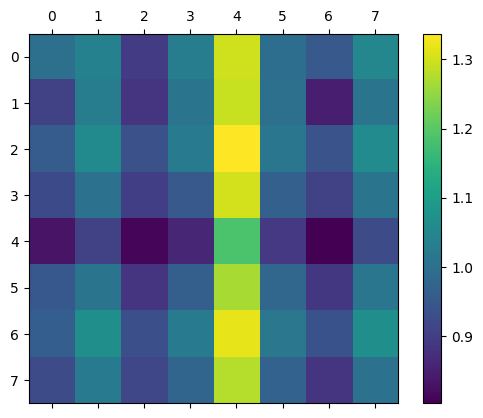

In [85]:
# x = np.insert(x_nontrivial, 0, 0)  # 在开头插入 x0 = 0
# x = x + 1

x.reshape(8, 8)
import matplotlib.pyplot as plt
figure = plt.figure()
axes = figure.add_subplot(111)

# using the matshow() function 
caxes = axes.matshow(x.reshape(8,8), interpolation ='nearest')
figure.colorbar(caxes)

原矩阵:
 [[1.         1.03810383 0.89478499 1.0294893  1.29931341 0.99696118
  0.95312342 1.05053596]
 [0.90560452 1.02864759 0.88246359 1.00851801 1.29239665 1.00065121
  0.84874881 1.00897774]
 [0.95904779 1.05943271 0.935129   1.02009148 1.33742993 1.01327094
  0.93994098 1.06011104]
 [0.92311906 1.00376507 0.90251172 0.95135637 1.30024814 0.96584895
  0.90557159 1.00802673]
 [0.83040117 0.90915371 0.80951496 0.85973461 1.18536825 0.89265226
  0.80286241 0.92618129]
 [0.94909886 1.00887292 0.88601758 0.96572436 1.26830495 0.98021694
  0.88907745 1.01313458]
 [0.9631633  1.06846476 0.93287986 1.0206868  1.31855797 1.01386626
  0.93769183 1.06914309]
 [0.92557227 1.0229466  0.91647198 0.97798313 1.27688386 0.97011633
  0.8827572  1.00327675]]
Zigzag 扫描结果:
 [1.         1.03810383 0.90560452 0.95904779 1.02864759 0.89478499
 1.0294893  0.88246359 1.05943271 0.92311906 0.83040117 1.00376507
 0.935129   1.00851801 1.29931341 0.99696118 1.29239665 1.02009148
 0.90251172 0.90915371 0.94909886 

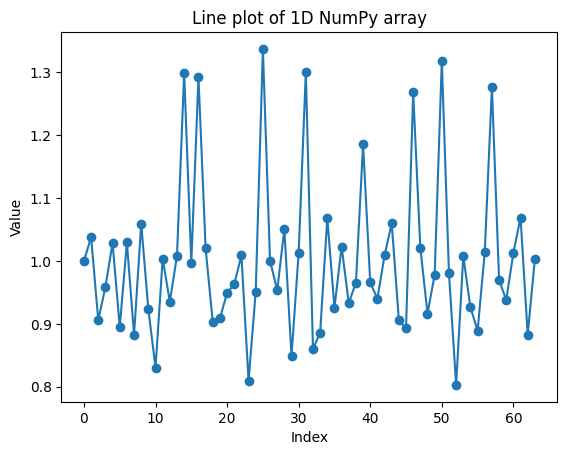

In [86]:
import numpy as np

def zigzag_scan(matrix):
    h, w = matrix.shape
    result = []
    for s in range(h + w - 1):
        if s % 2 == 0:
            # 从下到上
            for i in range(s, -1, -1):
                j = s - i
                if i < h and j < w:
                    result.append(matrix[i][j])
        else:
            # 从上到下
            for j in range(s, -1, -1):
                i = s - j
                if i < h and j < w:
                    result.append(matrix[i][j])
    return np.array(result)

# 示例
mat = x.reshape(8, 8)
print("原矩阵:\n", mat)
print("Zigzag 扫描结果:\n", zigzag_scan(mat))
# 方式 1: 折线图（常用）
plt.plot(zigzag_scan(mat), marker="o")
plt.title("Line plot of 1D NumPy array")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [5]:
from PIL import Image

# open JPEG
img = Image.open("/Users/haohan/Library/CloudStorage/Dropbox/macscript/local/bin/deep-learning/Paligemma/images.jpeg")

# get quantization tables
qtables = img.quantization

# print them
for table_id, table in qtables.items():
    print(f"Quantization Table {table_id}:")
    for i in range(0, 64, 8):
        print(table[i:i+8])
    print()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/haohan/Library/CloudStorage/Dropbox/macscript/local/bin/deep-learning/Paligemma/images.jpeg'

In [6]:
import numpy as np

means = np.zeros(64)
stds = np.array(qtables[0])
# stds = np.ones(64) 
samples = np.random.normal(loc=means, scale=stds)
print(samples)

NameError: name 'qtables' is not defined

In [16]:
M @ np.array(samples)

/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_7915/2568975723.py:1: RuntimeWarning: divide by zero encountered in matmul
  M @ np.array(samples)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_7915/2568975723.py:1: RuntimeWarning: overflow encountered in matmul
  M @ np.array(samples)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_7915/2568975723.py:1: RuntimeWarning: invalid value encountered in matmul
  M @ np.array(samples)


array([  5.13087356, -26.99778258,  29.83251505, -21.15051137,
        -2.62920015, -35.33046201, -53.37053704,  82.33951472,
        34.21824465,  17.39337134, -45.92240975,  25.06865924,
        64.32735612, -69.17338117,  44.4874641 , -33.28304404,
       -33.49439772, -17.47390318,  20.77682046, -28.37131891,
        51.19418193,  58.98508678, -95.87243309,  22.19421261,
        89.19363496, -37.67359537, -44.58198495,  74.04988869,
       -46.46925961, -35.15109228,   1.70818792,  -2.83530653,
       -54.11773931,  -5.07234876, -10.40206237, -29.10296423,
        60.12823607, -67.34526376,  53.17900491,   0.69510205,
        38.45470608, -42.18951655, -10.60575362,  -7.85120501,
         7.39149302,  40.39222633, -12.15367637, -13.77631435,
       -15.85489655,   4.49412618,  60.15334892,  20.45755338,
       -31.82469967,   7.79911089,  22.82634986,  -6.05864063,
       -26.53379618,  25.75656211,   5.88161306,   1.67720352,
        -8.6113312 ,  -8.87296303,  30.57015001, -22.96

In [ ]:
from PIL import Image
import numpy as np

BASE_QTABLE_LUMA = np.array([
    16,11,10,16,24,40,51,61,
    12,12,14,19,26,58,60,55,
    14,13,16,24,40,57,69,56,
    14,17,22,29,51,87,80,62,
    18,22,37,56,68,109,103,77,
    24,35,55,64,81,104,113,92,
    49,64,78,87,103,121,120,101,
    72,92,95,98,112,100,103,99,
])

def estimate_qf(filename):
    img = Image.open(filename)
    qtables = img.quantization
    qtable_luma = np.array(qtables[0])  # table 0 = luminance

    best_qf = None
    best_err = float("inf")

    for qf in range(1, 101):  # JPEG quality usually 1..100
        if qf < 50:
            scale = 5000 / qf
        else:
            scale = 200 - 2*qf
        scaled = np.floor((BASE_QTABLE_LUMA * scale + 50) / 100)
        scaled = np.clip(scaled, 1, 255)

        err = np.sum(np.abs(scaled - qtable_luma))
        if err < best_err:
            best_err = err
            best_qf = qf

    return best_qf

print("Estimated QF:", estimate_qf("example.jpg"))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/haohan/Library/CloudStorage/Dropbox/macscript/local/bin/ai/Paligemma/example.jpg'

In [ ]:
import numpy as np

# 标准 JPEG 亮度 (luminance) 和色度 (chrominance) 量化表
Q_lum_base = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

def scale_table(Q_base, quality):
    """按 JPEG 标准缩放量化表"""
    if quality < 50:
        S = 5000 / quality
    else:
        S = 200 - 2 * quality
    Q = np.floor((Q_base * S + 50) / 100)
    Q = np.clip(Q, 1, 255).astype(int)
    return Q

In [23]:
scale_table(Q_base=Q_lum_base, quality=70)

array([[10,  7,  6, 10, 14, 24, 31, 37],
       [ 7,  7,  8, 11, 16, 35, 36, 33],
       [ 8,  8, 10, 14, 24, 34, 41, 34],
       [ 8, 10, 13, 17, 31, 52, 48, 37],
       [11, 13, 22, 34, 41, 65, 62, 46],
       [14, 21, 33, 38, 49, 62, 68, 55],
       [29, 38, 47, 52, 62, 73, 72, 61],
       [43, 55, 57, 59, 67, 60, 62, 59]])

In [ ]:
import numpy as np
import cv2

# Read PNG image (BGR by default in OpenCV)
img_bgr = cv2.imread("png.png")

# Convert BGR to YCrCb
img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)

# Split into Y, Cr, Cb channels if needed
Y, Cr, Cb = cv2.split(img_ycrcb)

Y = np.float32(Y)

QY = np.array([
    [16,  11,  10,  16,  24,  40,  51,  61],
    [12,  12,  14,  19,  26,  58,  60,  55],
    [14,  13,  16,  24,  40,  57,  69,  56],
    [14,  17,  22,  29,  51,  87,  80,  62],
    [18,  22,  37,  56,  68, 109, 103,  77],
    [24,  35,  55,  64,  81, 104, 113,  92],
    [49,  64,  78,  87, 103, 121, 120, 101],
    [72,  92,  95,  98, 112, 100, 103,  99],
])

QY90 = np.array([
       [ 3,  2,  2,  3,  5,  8, 10, 12],
       [ 2,  2,  3,  4,  5, 12, 12, 11],
       [ 3,  3,  3,  5,  8, 11, 14, 11],
       [ 3,  3,  4,  6, 10, 17, 16, 12],
       [ 4,  4,  7, 11, 14, 22, 21, 15],
       [ 5,  7, 11, 13, 16, 21, 23, 18],
       [10, 13, 16, 17, 21, 24, 24, 20],
       [14, 18, 19, 20, 22, 20, 21, 20]
])

distance_blocks = []

h, w = Y.shape
for i in range(0, h, 8):
    for j in range(0, w, 8):
        block = Y[i:i+8, j:j+8]
        if block.shape[0] != 8 or block.shape[1] != 8:
            continue

        # DCT
        dct_block = cv2.dct(block - 128) # shift for JPEG-style
        # Quantization
        quant_block = np.round(dct_block / QY)
        # Unquantization
        dequant_block = quant_block * QY
        # IDCT
        idct_block = cv2.idct(dequant_block) + 128
        distance_block = block - idct_block
        distance_blocks.append(distance_block)


print("Image shape (BGR):", img_bgr.shape)
print("Image shape (YCrCb):", img_ycrcb.shape)
print("Y channel shape:", Y.shape)

Image shape (BGR): (420, 560, 3)
Image shape (YCrCb): (420, 560, 3)
Y channel shape: (420, 560)


In [ ]:
import numpy as np
import cv2
import os


def get_distance():
    root_dir = "/Users/haohan/Downloads/images/photo_tecnick"
    count = 0
    dct_distance_blocks = []
    yuv_distance_blocks = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(".png"):
                print(filename)
                count += 1
                if count == 100:
                    return dct_distance_blocks, yuv_distance_blocks 
                filepath = os.path.join(dirpath, filename)
                # Read PNG image (BGR by default in OpenCV)
                img_bgr = cv2.imread(filepath)

                # Convert BGR to YCrCb
                img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)

                # Split into Y, Cr, Cb channels if needed
                Y, Cr, Cb = cv2.split(img_ycrcb)

                Y = np.float32(Y)

                # QY = np.array([
                #     [16,  11,  10,  16,  24,  40,  51,  61],
                #     [12,  12,  14,  19,  26,  58,  60,  55],
                #     [14,  13,  16,  24,  40,  57,  69,  56],
                #     [14,  17,  22,  29,  51,  87,  80,  62],
                #     [18,  22,  37,  56,  68, 109, 103,  77],
                #     [24,  35,  55,  64,  81, 104, 113,  92],
                #     [49,  64,  78,  87, 103, 121, 120, 101],
                #     [72,  92,  95,  98, 112, 100, 103,  99],
                # ])

                # QY = np.array([
                #     [ 3,  2,  2,  3,  5,  8, 10, 12],
                #     [ 2,  2,  3,  4,  5, 12, 12, 11],
                #     [ 3,  3,  3,  5,  8, 11, 14, 11],
                #     [ 3,  3,  4,  6, 10, 17, 16, 12],
                #     [ 4,  4,  7, 11, 14, 22, 21, 15],
                #     [ 5,  7, 11, 13, 16, 21, 23, 18],
                #     [10, 13, 16, 17, 21, 24, 24, 20],
                #     [14, 18, 19, 20, 22, 20, 21, 20]
                # ])

                # QY = np.array([
                #     [10,  7,  6, 10, 14, 24, 31, 37],
                #     [ 7,  7,  8, 11, 16, 35, 36, 33],
                #     [ 8,  8, 10, 14, 24, 34, 41, 34],
                #     [ 8, 10, 13, 17, 31, 52, 48, 37],
                #     [11, 13, 22, 34, 41, 65, 62, 46],
                #     [14, 21, 33, 38, 49, 62, 68, 55],
                #     [29, 38, 47, 52, 62, 73, 72, 61],
                #     [43, 55, 57, 59, 67, 60, 62, 59]
                # ])

                QY = np.array([
                    [25, 12, 13,  8, 13,  19,  26,  38],
                    [14, 14,  9, 10, 19,  19,  27,  45],
                    [13, 10, 12, 19, 24,  20,  34,  35],
                    [11, 12, 19, 19, 23,  30,  45,  50],
                    [12, 19, 18, 25, 34,  34,  35,  77],
                    [23, 23, 20, 35, 35,  43, 108,  70],
                    [22, 23, 27, 36, 43,  83,  76,  55],
                    [30, 28, 35, 60, 80, 115,  55, 105]
                ])


                h, w = Y.shape
                for i in range(0, h, 8):
                    for j in range(0, w, 8):
                        block = Y[i:i+8, j:j+8]
                        if block.shape[0] != 8 or block.shape[1] != 8:
                            continue

                        # DCT
                        dct_block = cv2.dct(block - 128) # shift for JPEG-style
                        # Quantization
                        quant_block = np.round(dct_block / QY)
                        # Unquantization
                        dequant_block = quant_block * QY
                        # IDCT
                        idct_block = cv2.idct(dequant_block) + 128
                        dct_distance_block = dct_block - dequant_block
                        yuv_distance_block = block - idct_block
                        dct_distance_blocks.append(dct_distance_block) 
                        yuv_distance_blocks.append(yuv_distance_block) 
                print("Image shape (BGR):", img_bgr.shape)
                print("Image shape (YCrCb):", img_ycrcb.shape)
                print("Y channel shape:", Y.shape)   


In [2]:
distance_blocks = get_distance()
len(distance_blocks)

RGB_OR_1200x1200_001.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_015.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_029.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_028.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_014.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_016.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_002.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_003.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shap

libpng warning: iCCP: known incorrect sRGB profile


Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_098.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_099.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_072.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_066.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_043.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_057.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_080.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_12

2

In [70]:
distance_blocks[0]

[array([[ 4.50000000e+00, -2.27559388e-01,  1.34619105e+00,
          1.12018812e+00, -2.49999970e-01,  8.48696083e-02,
         -1.64145324e-02, -2.47371107e-01],
        [-1.07140851e+00,  1.78958142e+00,  3.69803667e-01,
         -8.11058208e-02, -3.49325240e-01, -9.56708416e-02,
         -2.74943590e-01, -1.79193139e-01],
        [-6.92903697e-01,  8.39051127e-01,  1.03553355e-01,
         -3.75996947e-01, -3.66268903e-01, -5.62719166e-01,
          5.24735633e-09,  3.73822182e-01],
        [-1.08489007e-01, -2.30969906e-01, -6.48820698e-01,
         -3.30257326e-01,  9.53667998e-01,  3.97447526e-01,
          1.99775487e-01,  5.41931801e-02],
        [ 2.50016451e-01, -8.39266926e-02,  3.66268933e-01,
          4.10484433e-01,  4.99999970e-01, -3.89339268e-01,
         -4.22311574e-01, -2.18800768e-01],
        [-4.35426325e-01, -4.07746643e-01,  4.33528185e-01,
         -2.06105858e-01, -7.52282917e-01,  1.95970833e-02,
          1.67186707e-01, -2.30969891e-01],
        [ 2.8698

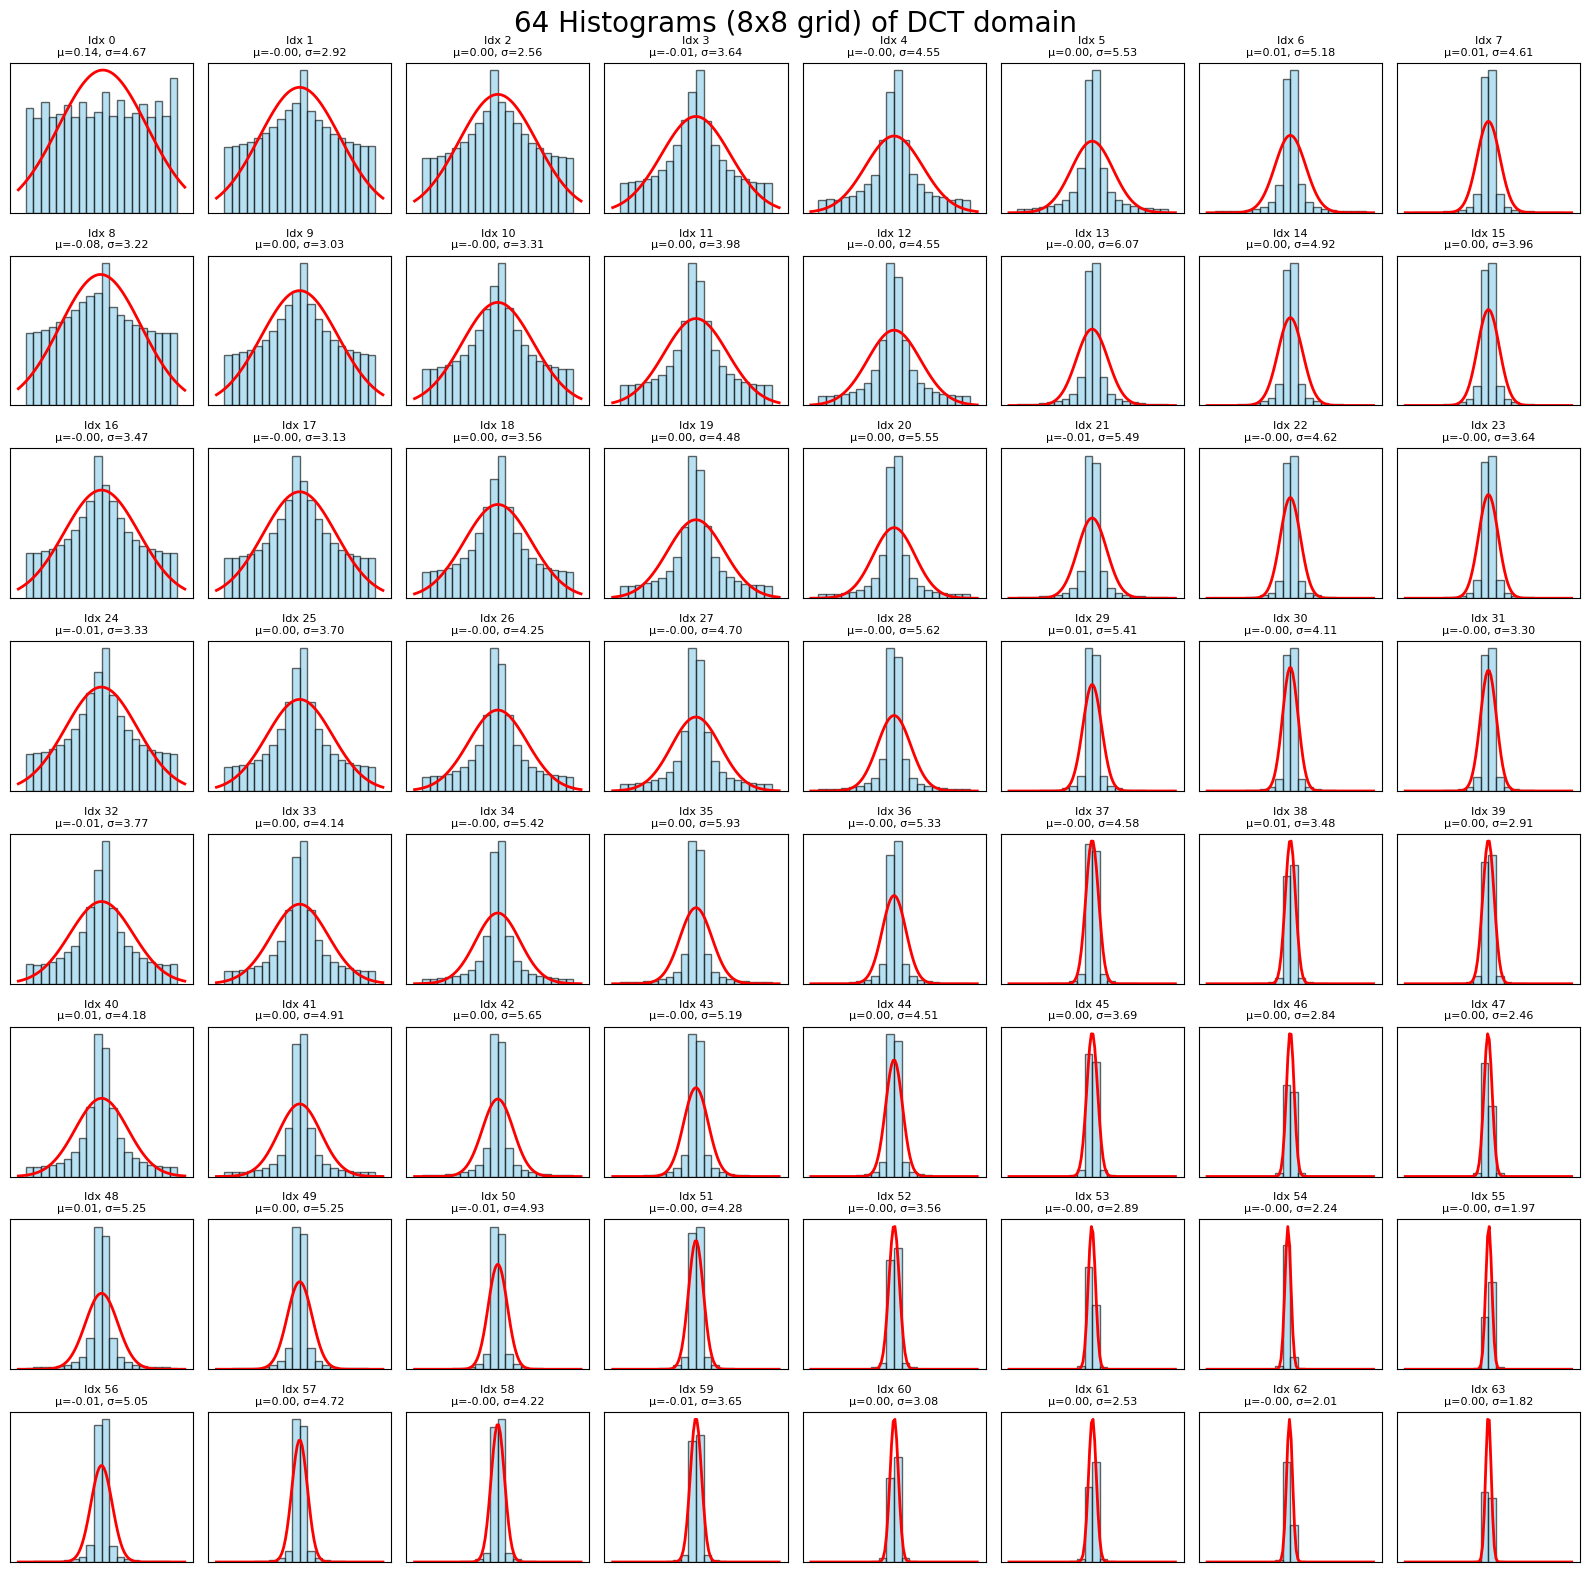

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

values = []
stds = []
for i in range(8):
    for j in range(8):
        values.append(np.array([distance_blocks[0][k][i][j] for k in range(len(distance_blocks[0]))]))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
fig.suptitle("64 Histograms (8x8 grid) of DCT domain", fontsize=20)
for idx, ax in enumerate(axes.flat):
    data = values[idx]
    ax.hist(data, bins=20, density=True, alpha=0.6, color="skyblue", edgecolor="black")
    # Overlay Gaussian fit
    mu, std = stats.norm.fit(data)
    stds.append(std)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    ax.set_title(f"Idx {idx}\nμ={mu:.2f}, σ={std:.2f}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.savefig("dct_histograms.png", dpi=300, bbox_inches="tight")
plt.show()


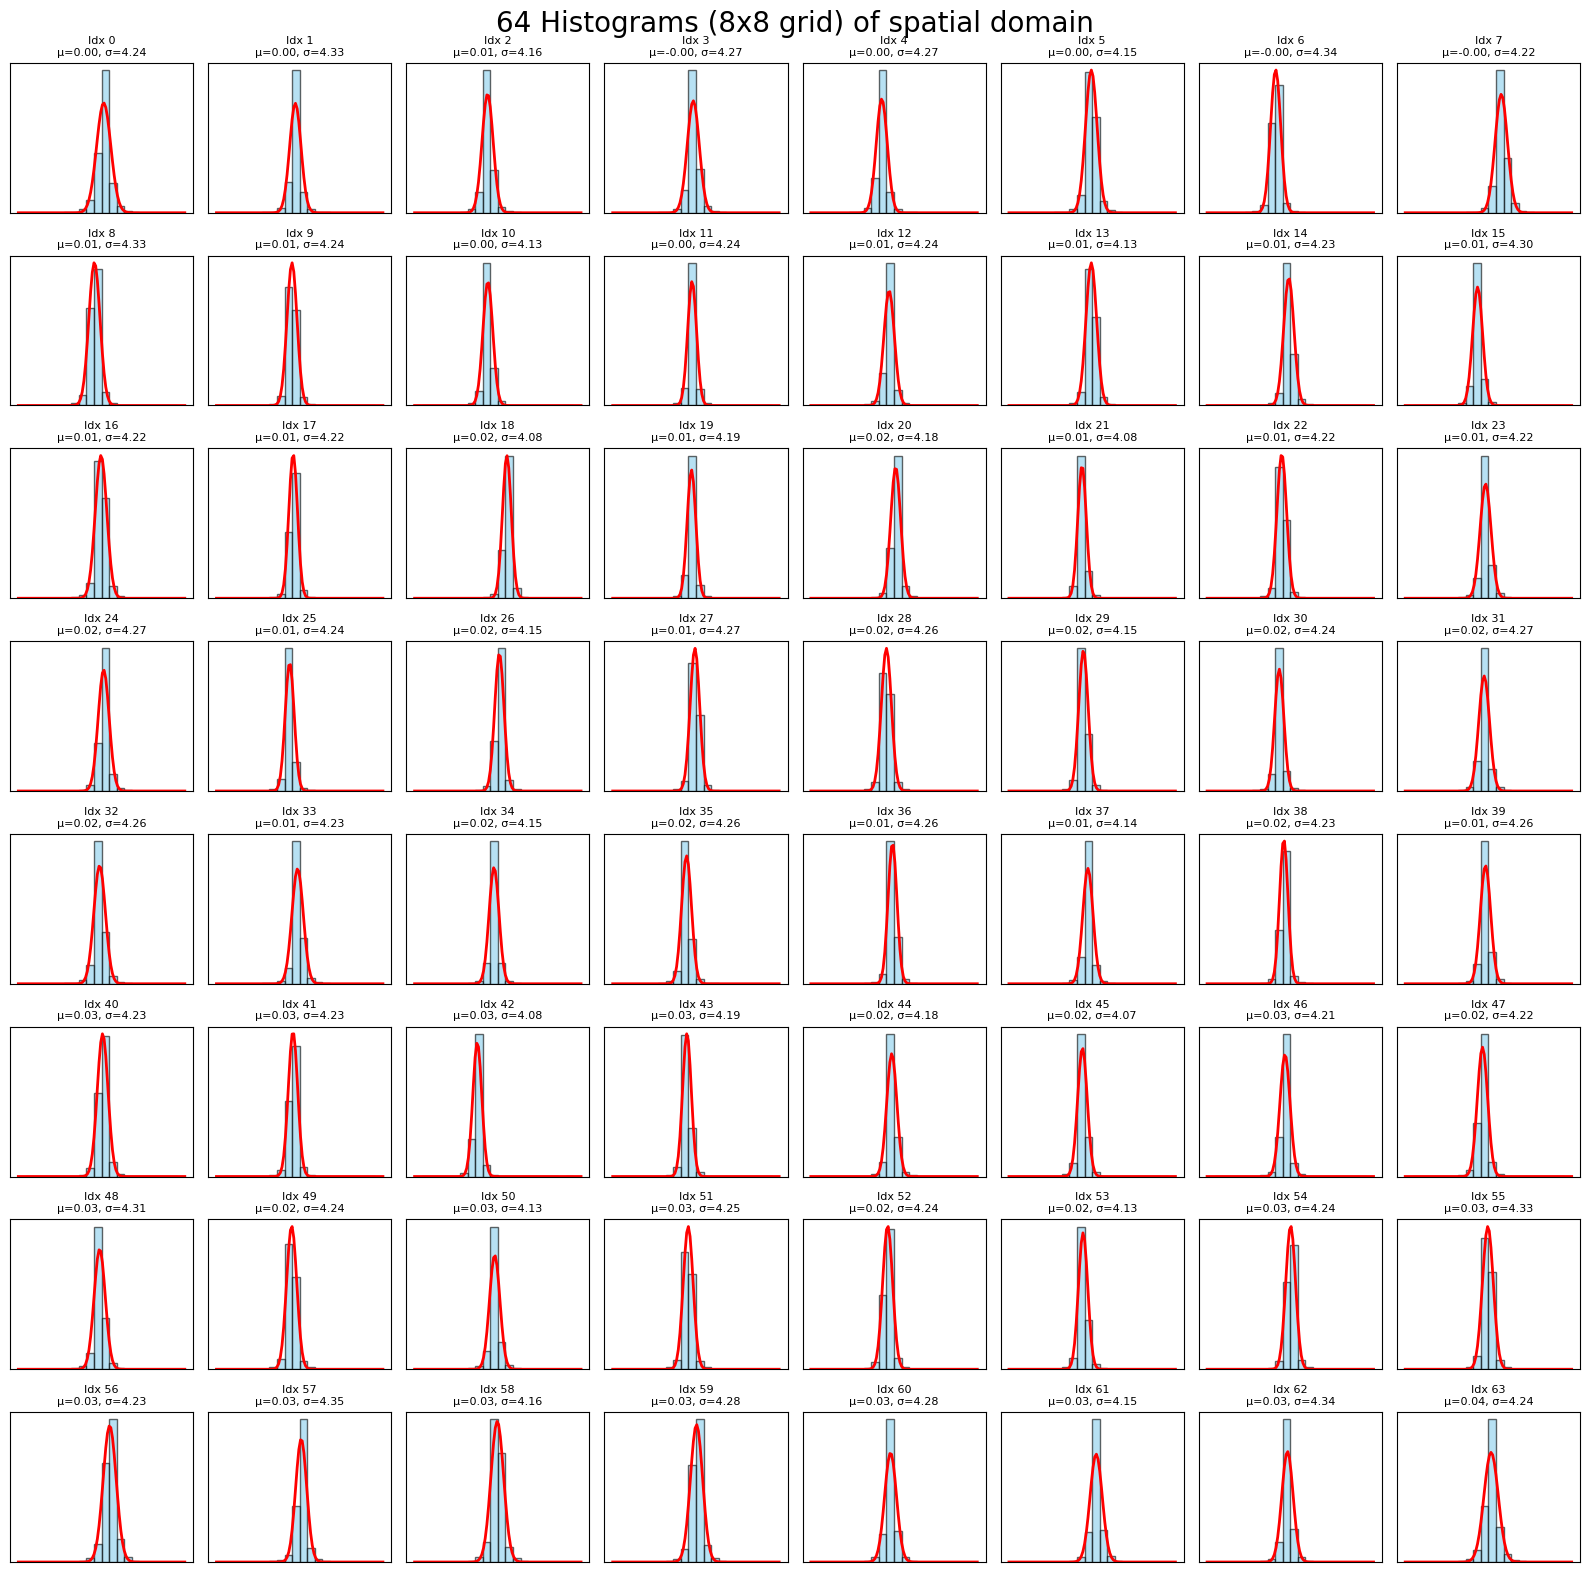

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

values = []
for i in range(8):
    for j in range(8):
        values.append(np.array([distance_blocks[1][k][i][j] for k in range(len(distance_blocks[1]))]))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
fig.suptitle("64 Histograms (8x8 grid) of spatial domain", fontsize=20)
for idx, ax in enumerate(axes.flat):
    data = values[idx]
    ax.hist(data, bins=20, density=True, alpha=0.6, color="skyblue", edgecolor="black")
    # Overlay Gaussian fit
    mu, std = stats.norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    ax.set_title(f"Idx {idx}\nμ={mu:.2f}, σ={std:.2f}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("idct_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

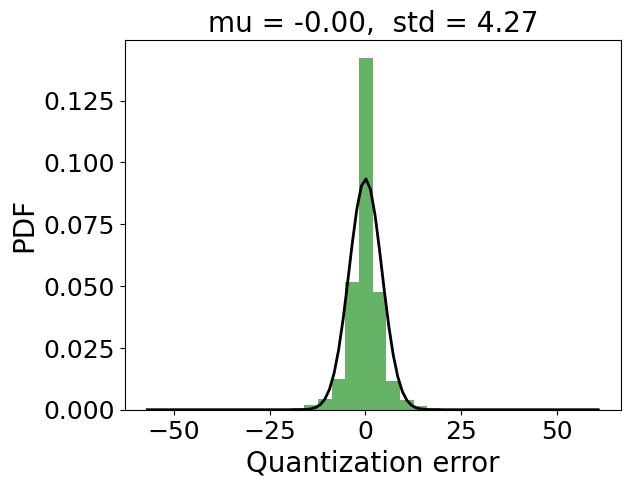

Shapiro-Wilk test: stat=0.894, p=0.000
Kolmogorov-Smirnov test: stat=0.110, p=0.000


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate some sample data (Normal with mean=0, std=1)
# data = np.random.normal(0, 1, 500)
data = np.array([distance_blocks[1][i][0][3] for i in range(len(distance_blocks[1]))])

# --- Visual check ---
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Overlay Gaussian fit
mu, std = stats.norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title(f"mu = {mu:.2f},  std = {std:.2f}", fontsize=20)
plt.xlabel("Quantization error", fontsize=20)
plt.ylabel("PDF", fontsize=20)
plt.tick_params(axis='x', labelsize=18)  # 横轴字号
plt.tick_params(axis='y', labelsize=18)  # 纵轴字号
plt.savefig("50-16.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Statistical tests ---
# Shapiro-Wilk test (for normality)
stat, p_value = stats.shapiro(data)
print("Shapiro-Wilk test: stat=%.3f, p=%.3f" % (stat, p_value))

# Kolmogorov-Smirnov test (compare to N(0,1))
stat, p_value = stats.kstest(data, 'norm', args=(mu, std))
print("Kolmogorov-Smirnov test: stat=%.3f, p=%.3f" % (stat, p_value))

In [54]:
len(distance_blocks)

360360

In [49]:
values = [np.random.randn(100) for _ in range(64)]

In [51]:
len(values)

64

In [1]:
import torch

x = torch.arange(10)   # tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Take every second element: [1, 3, 5, 7, 9]
y = x[1::2]

# Get the maximum value using torch.topk
max_val, max_idx = torch.topk(y, k=1)

print("y:", y)
print("max value:", max_val.item())
print("index in y:", max_idx.item())

y: tensor([1, 3, 5, 7, 9])
max value: 9
index in y: 4


In [4]:
x = torch.tensor([[1, 2, 3,4,5],
                  [11, 12,13,14,15],
                  [21, 22,23,24,25],
                  [31, 32,33,34,35],
                  [41, 42,43,44,45],])   # shape (2, 2)
x.shape

torch.Size([5, 5])

In [5]:
x[1::2]

tensor([[11, 12, 13, 14, 15],
        [31, 32, 33, 34, 35]])

In [6]:
1 //128 *128

0

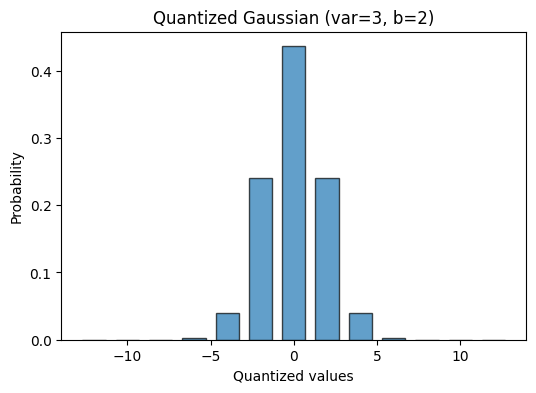

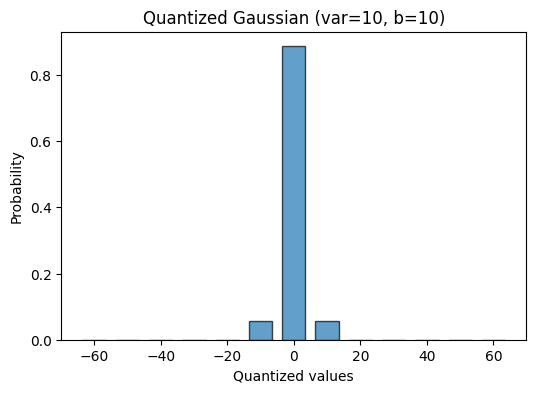

(array([-60, -50, -40, -30, -20, -10,   0,  10,  20,  30,  40,  50,  60]),
 array([4.69983899e-68, 2.97346239e-46, 8.97076212e-29, 1.33222319e-15,
        1.05071798e-06, 5.69220983e-02, 8.86153702e-01, 5.69220983e-02,
        1.05071798e-06, 1.33226763e-15, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]))

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def quantized_distribution(a, b, k_range=6):
    """
    a: 方差
    b: 量化步长
    k_range: 考虑多少个离散点 (±k_range*b)
    """
    sigma = np.sqrt(a)
    xs = np.arange(-k_range, k_range + 1) * b
    probs = []
    for k in range(-k_range, k_range + 1):
        left = (k - 0.5) * b
        right = (k + 0.5) * b
        p = norm.cdf(right, loc=0, scale=sigma) - norm.cdf(left, loc=0, scale=sigma)
        probs.append(p)

    probs = np.array(probs)

    # 画柱状图
    plt.figure(figsize=(6,4))
    plt.bar(xs, probs, width=b*0.7, alpha=0.7, edgecolor="black")
    plt.title(f"Quantized Gaussian (var={a}, b={b})")
    plt.xlabel("Quantized values")
    plt.ylabel("Probability")
    plt.show()

    return xs, probs

# 示例
quantized_distribution(a=3, b=2)
quantized_distribution(a=10, b=10)

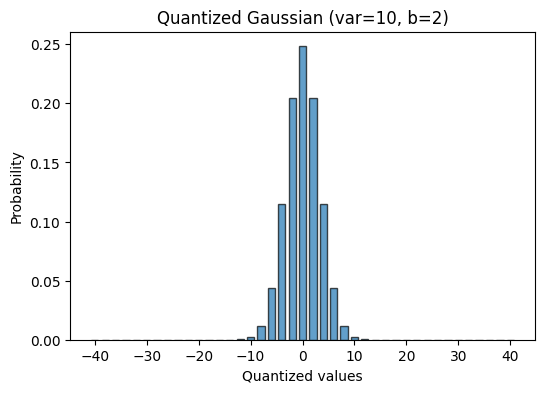

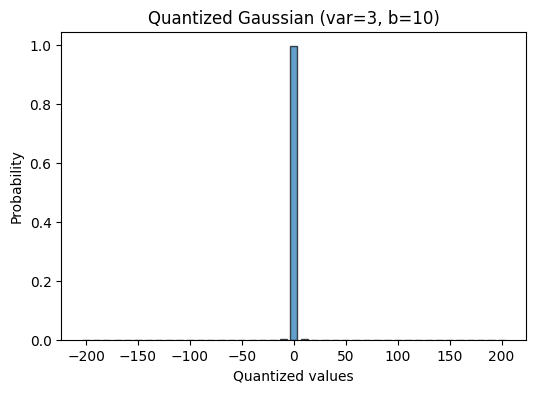

(array([-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,
         -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,
          20,   30,   40,   50,   60,   70,   80,   90,  100,  110,  120,
         130,  140,  150,  160,  170,  180,  190,  200]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.62387215e-308, 1.38636335e-221, 4.08535220e-149,
        4.22560388e-091, 1.58658002e-047, 2.35357030e-018, 1.94620856e-003,
        9.96107583e-001, 1.94620856e-003, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e

In [94]:
quantized_distribution(a=10, b=2, k_range=20)
quantized_distribution(a=3, b=10, k_range=20)